<a href="https://colab.research.google.com/github/hajonghyun/installPytorch_study/blob/main/5_1_short_multiclass_classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/ROKAF/인스톨 파이토치/torch_코드모음')
from multiclass_functions1 import * # all
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


In [9]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = False
model_type = 'MLP'
dataset = 'MNIST'
save_model_path = f"/content/drive/MyDrive/ROKAF/인스톨 파이토치/results/{model_type}_{dataset}.pt"

In [10]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root='/content/drive/MyDrive/ROKAF/인스톨 파이토치/data', train=True, download=True, transform= transform)
test_DS = datasets.MNIST(root='/content/drive/MyDrive/ROKAF/인스톨 파이토치/data', train=False, download=True, transform= transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS,
batch_size= BATCH_SIZE, shuffle=True)

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fcs = nn.Sequential(nn.Linear(28*28, 30),
                                 nn.BatchNorm1d(30),
                                 nn.ReLU(),
                                 nn.Linear(30,10))
    def forward(self,x):
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

In [12]:
model = globals()[model_type]().to(DEVICE)
# globals() => global 변수들이 딕셔너리 형태로. 따라서 globals()[model_type]는 model_type이 'MLP'로 설정되어있으므로 'MLP'라는 string으로 인덱싱한 것

print(model)

x_batch, _ = next(iter(train_DL))
print(x_batch.shape)

model.eval()
with torch.no_grad():
    print(model(x_batch.to(DEVICE)).shape)

MLP(
  (fcs): Sequential(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=30, out_features=10, bias=True)
  )
)
torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


Epoch: 1, train loss: 0.416
--------------------
Epoch: 2, train loss: 0.211
--------------------
Epoch: 3, train loss: 0.171
--------------------
Epoch: 4, train loss: 0.149
--------------------
Epoch: 5, train loss: 0.135
--------------------


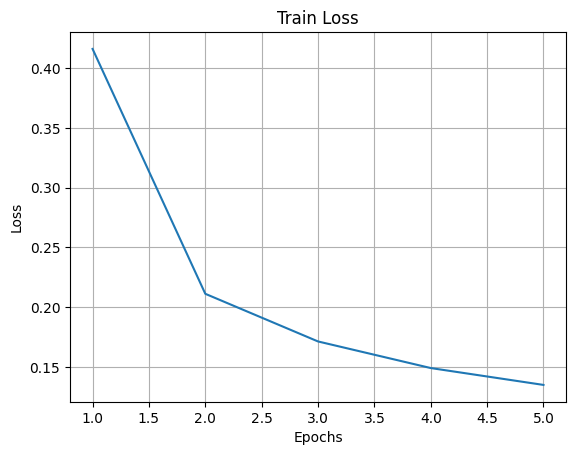

In [13]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1,EPOCH+1), loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss")
    plt.grid()

In [16]:
load_model = torch.load(save_model_path, map_location=DEVICE, weights_only=False)

In [17]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 9646/10000 (96.5 %)
23920


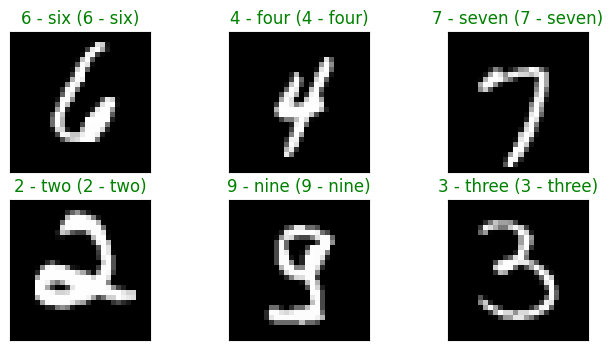

In [30]:
Test_plot(load_model, test_DL)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0 - zero'),
  Text(1, 0, '1 - one'),
  Text(2, 0, '2 - two'),
  Text(3, 0, '3 - three'),
  Text(4, 0, '4 - four'),
  Text(5, 0, '5 - five'),
  Text(6, 0, '6 - six'),
  Text(7, 0, '7 - seven'),
  Text(8, 0, '8 - eight'),
  Text(9, 0, '9 - nine')])

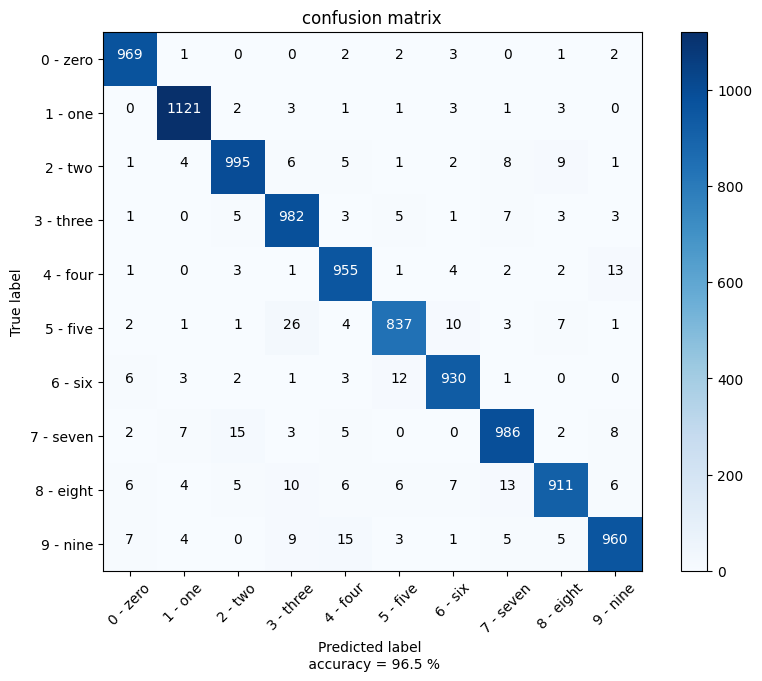

In [31]:
confusion = get_conf(load_model, test_DL)
plot_confusion_matrix(confusion, test_DS.classes)
plt.xticks(rotation=45)

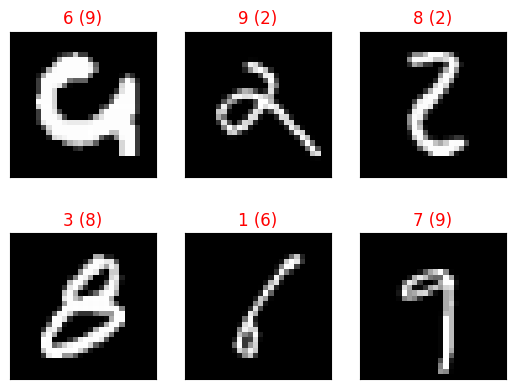

In [32]:
# 틀린 것만 모아서 보자
cnt = 0
load_model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_DL:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_hat = load_model(x_batch)
        pred = y_hat.argmax(dim=1)

        false_idx = pred!=y_batch
        X_false=x_batch[false_idx,...].to("cpu")
        pred_false=pred[false_idx,...].to("cpu")
        Y_false=y_batch[false_idx,...].to("cpu")

        if X_false.shape[0] != 0:
            if cnt==6:
                break
            for i in range(X_false.shape[0]):
                cnt += 1
                pred_class = pred_false[i].item()
                true_class = Y_false[i].item()
                plt.subplot(2,3, cnt, xticks=[], yticks=[])
                plt.imshow(X_false[i,0,...], cmap="gray")
                plt.title(f"{pred_class} ({true_class})",color=("g" if pred_class==true_class else "r"))
                if cnt==6:
                    break